In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import precision_score

# Làm sạch dữ liệu

### SmallDS_Raw

In [ ]:
matches_small = pd.read_csv("./raw data/SmallDS_raw.csv")

# Loại bỏ những dữ liệu không cần thiết cho việc dự đoán
del matches_small["match report"]
del matches_small["notes"]
del matches_small["attendance"]
del matches_small["referee"]
del matches_small["formation"]
del matches_small["captain"]

In [ ]:
matches_small.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,xga,poss,sh,sot,dist,fk,pk,pkatt,season,team
0,2022-05-22,16:00,Premier League,Matchweek 38,Sun,Home,W,3,2,Aston Villa,...,0.2,71.0,24.0,5.0,14.2,1.0,0.0,0.0,2021,Manchester City
1,2022-05-22,16:00,Premier League,Matchweek 38,Sun,Home,W,3,1,Wolves,...,1.3,63.0,29.0,7.0,15.6,0.0,0.0,0.0,2021,Liverpool
2,2022-05-22,16:00,Premier League,Matchweek 38,Sun,Home,W,2,1,Watford,...,0.6,71.0,19.0,8.0,16.9,0.0,0.0,0.0,2021,Chelsea
3,2022-05-22,16:00,Premier League,Matchweek 38,Sun,Away,W,5,0,Norwich City,...,0.5,59.0,19.0,12.0,14.9,0.0,0.0,0.0,2021,Tottenham Hotspur
4,2022-05-22,16:00,Premier League,Matchweek 38,Sun,Home,W,5,1,Everton,...,1.1,73.0,25.0,8.0,17.0,0.0,1.0,1.0,2021,Arsenal


In [ ]:
matches_small.shape

(1000, 21)

In [ ]:
matches_small.isna().sum()

date        0
time        0
comp        0
round       0
day         0
venue       0
result      0
gf          0
ga          0
opponent    0
xg          0
xga         0
poss        0
sh          0
sot         0
dist        0
fk          0
pk          0
pkatt       0
season      0
team        0
dtype: int64

In [ ]:
matches_small['season'].unique()

array([2021, 2020], dtype=int64)

In [ ]:
matches_small['ga'].unique()

array([2, 1, 0, 3, 4, 5, 6, 7], dtype=int64)

In [ ]:
matches_small['team'].unique()

array(['Manchester City', 'Liverpool', 'Chelsea', 'Tottenham Hotspur',
       'Arsenal', 'Manchester United', 'West Ham United',
       'Leicester City', 'Brighton and Hove Albion',
       'Wolverhampton Wanderers', 'Newcastle United', 'Crystal Palace',
       'Brentford', 'Aston Villa', 'Southampton', 'Everton',
       'Leeds United', 'Burnley', 'Watford', 'Norwich City', 'Fulham',
       'West Bromwich Albion', 'Sheffield United'], dtype=object)

In [ ]:
matches_small['opponent'].unique()

array(['Aston Villa', 'Wolves', 'Watford', 'Norwich City', 'Everton',
       'Crystal Palace', 'Brighton', 'Southampton', 'West Ham',
       'Liverpool', 'Burnley', 'Manchester Utd', 'Leeds United',
       'Manchester City', 'Leicester City', 'Arsenal', 'Brentford',
       'Newcastle Utd', 'Chelsea', 'Tottenham', 'West Brom', 'Fulham',
       'Sheffield Utd'], dtype=object)

In [ ]:
list_team = np.array(matches_small['team'].unique())
list_opp = np.array(matches_small['opponent'].unique())
result = np.concatenate((list_team, list_opp))
unique_values, counts = np.unique(result, return_counts=True)
result = unique_values[counts == 1]
print(result)

['Brighton' 'Brighton and Hove Albion' 'Manchester United'
 'Manchester Utd' 'Newcastle United' 'Newcastle Utd' 'Sheffield United'
 'Sheffield Utd' 'Tottenham' 'Tottenham Hotspur' 'West Brom'
 'West Bromwich Albion' 'West Ham' 'West Ham United'
 'Wolverhampton Wanderers' 'Wolves']


In [ ]:
class MissingDict(dict):
    __missing__ = lambda self, key: key
map_values = {"Brighton and Hove Albion": "Brighton", "Manchester United": "Manchester Utd", "Newcastle United": "Newcastle Utd","Sheffield United": "Sheffield Utd" , "Tottenham Hotspur": "Tottenham", "West Ham United": "West Ham", "Wolverhampton Wanderers": "Wolves"} 
mapping = MissingDict(**map_values)
matches_small["team"] = matches_small["team"].map(mapping)
matches_small["opponent"] = matches_small["opponent"].map(mapping)

In [ ]:
matches_small.to_csv('./clean data/SmallDS.csv', index=False)

### BigDS_Raw

In [ ]:
matches_big = pd.read_csv("./raw data/BigDS_raw.csv")
del matches_big["match report"]
del matches_big["notes"]
del matches_big["attendance"]
del matches_big["referee"]
del matches_big["formation"]
del matches_big["captain"]

In [ ]:
matches_big.shape

(10000, 21)

In [ ]:
matches_big.isna().sum()

date           0
time           0
comp           0
round          0
day            0
venue          0
result         0
gf             0
ga             0
opponent       0
xg          1746
xga         1746
poss           2
sh             2
sot            2
dist        1750
fk          2506
pk             2
pkatt          2
season         0
team           0
dtype: int64

In [ ]:
matches_big['season'].unique()

array([2021, 2020, 2019, 2018, 2017, 2016], dtype=int64)

In [ ]:
matches_big['ga'].unique()

array(['2', '1', '0', '3', '4', '5', '6', '7', '9', '8', '2 (2)', '1 (3)',
       '2.0', '1.0', '3.0', '0.0', '4.0', '5.0', '8.0', '6.0', '7.0',
       '0 (4)'], dtype=object)

In [ ]:
matches_big["ga"] = matches_big["ga"].str.replace(".0", "")
matches_big['ga'] = matches_big['ga'].str.split(' ').str[0].astype(int)
matches_big['ga'].unique()

array([2, 1, 0, 3, 4, 5, 6, 7, 9, 8])

In [ ]:
matches_big['gf'].unique()

array(['3', '2', '5', '0', '1', '4', '6', '7', '9', '8', '1 (3)', '2 (2)',
       '1.0', '2.0', '3.0', '0.0', '4.0', '5.0', '8.0', '6.0', '7.0',
       '0 (4)'], dtype=object)

In [ ]:
matches_big["gf"] = matches_big["gf"].str.replace(".0", "")
matches_big['gf'] = matches_big['gf'].str.split(' ').str[0].astype(int)
matches_big['gf'].unique()

array([3, 2, 5, 0, 1, 4, 6, 7, 9, 8])

In [ ]:
class MissingDict(dict):
    __missing__ = lambda self, key: key
map_values = {"Brighton and Hove Albion": "Brighton", "Manchester United": "Manchester Utd", "Newcastle United": "Newcastle Utd","Sheffield United": "Sheffield Utd" , "Tottenham Hotspur": "Tottenham", "West Ham United": "West Ham", "Wolverhampton Wanderers": "Wolves"} 
mapping = MissingDict(**map_values)
matches_big["team"] = matches_big["team"].map(mapping)
matches_big["opponent"] = matches_big["opponent"].map(mapping)

In [ ]:
matches_big.to_csv('./clean data/BigDS.csv', index=False)

# Xử lý dữ liệu trống

### BigDS

In [ ]:
matches_big = pd.read_csv("./clean data/BigDS.csv")

In [ ]:
matches_big.shape

(10000, 21)

In [ ]:
matches_big.isna().sum()

date           0
time           0
comp           0
round          0
day            0
venue          0
result         0
gf             0
ga             0
opponent       0
xg          1746
xga         1746
poss           2
sh             2
sot            2
dist        1750
fk          2506
pk             2
pkatt          2
season         0
team           0
dtype: int64

In [ ]:
mean = matches_big.groupby(['team', 'opponent'])[['xg', 'xga', 'dist', 'fk', 'pk', 'pkatt', 'poss', 'sh', 'sot']].transform('mean')
matches_big['xg'].fillna(mean['xg'], inplace=True)
matches_big['xga'].fillna(mean['xga'], inplace=True)
matches_big['dist'].fillna(mean['dist'], inplace=True)
matches_big['fk'].fillna(mean['fk'], inplace=True)
matches_big['pk'].fillna(mean['pk'], inplace=True)
matches_big['pkatt'].fillna(mean['pkatt'], inplace=True)
matches_big['poss'].fillna(mean['poss'], inplace=True)
matches_big['sh'].fillna(mean['sh'], inplace=True)
matches_big['sot'].fillna(mean['sot'], inplace=True)

In [ ]:
matches_big.isna().sum()

date          0
time          0
comp          0
round         0
day           0
venue         0
result        0
gf            0
ga            0
opponent      0
xg          412
xga         412
poss          0
sh            0
sot           0
dist        412
fk          628
pk            0
pkatt         0
season        0
team          0
dtype: int64

In [ ]:
matches_big.to_csv('./clean data/BigDS.csv', index=False)

### SmallDS

In [ ]:
matches_small = pd.read_csv("./clean data/SmallDS.csv")

In [ ]:
matches_small.shape

(1000, 21)

In [ ]:
matches_small.isna().sum()

date        0
time        0
comp        0
round       0
day         0
venue       0
result      0
gf          0
ga          0
opponent    0
xg          0
xga         0
poss        0
sh          0
sot         0
dist        0
fk          0
pk          0
pkatt       0
season      0
team        0
dtype: int64

# SmallDS

In [ ]:
matches = matches_small

In [ ]:
matches.shape

(1000, 21)

In [ ]:
matches.dtypes

date         object
time         object
comp         object
round        object
day          object
venue        object
result       object
gf            int64
ga            int64
opponent     object
xg          float64
xga         float64
poss        float64
sh          float64
sot         float64
dist        float64
fk          float64
pk          float64
pkatt       float64
season        int64
team         object
dtype: object

In [ ]:
matches["date"] = pd.to_datetime(matches["date"])

In [ ]:
# Chuyển đổi dữ liệu về dạng số
matches["venue_code"] = matches["venue"].astype("category").cat.codes
matches["opp_code"] = matches["opponent"].astype("category").cat.codes
matches["round_code"] = matches["round"].astype("category").cat.codes
matches["comp_code"] = matches['comp'].apply(lambda x: 1 if x == 'Premier League' else 2)
matches["day"] = matches["date"].dt.dayofweek + 2
matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype("int")
# thêm cột target là 1 nêu cột result là 'W' và là 0 nếu 'D' hoặc 'L'
matches['target'] = matches['result'].apply(lambda x: 1 if x == 'W' else 0)
# thêm cột goals_dif (số bàn thắng đội nhà trừ số bàn thắng đội đối đầu)
matches['goals_dif'] = matches['gf'] - matches['ga']
matches["point_win"] = matches["result"].astype("category").cat.codes
matches

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,season,team,venue_code,opp_code,round_code,comp_code,hour,target,goals_dif,point_win
0,2022-05-22,16:00,Premier League,Matchweek 38,8,Home,W,3,2,Aston Villa,...,2021,Manchester City,1,1,31,1,16,1,1,2
1,2022-05-22,16:00,Premier League,Matchweek 38,8,Home,W,3,1,Wolves,...,2021,Liverpool,1,22,31,1,16,1,2,2
2,2022-05-22,16:00,Premier League,Matchweek 38,8,Home,W,2,1,Watford,...,2021,Chelsea,1,19,31,1,16,1,1,2
3,2022-05-22,16:00,Premier League,Matchweek 38,8,Away,W,5,0,Norwich City,...,2021,Tottenham,0,15,31,1,16,1,5,2
4,2022-05-22,16:00,Premier League,Matchweek 38,8,Home,W,5,1,Everton,...,2021,Arsenal,1,7,31,1,16,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2021-03-04,18:00,Premier League,Matchweek 29,5,Home,L,0,1,Everton,...,2020,West Bromwich Albion,1,7,21,1,18,0,-1,1
996,2021-03-03,20:15,Premier League,Matchweek 29,4,Away,D,0,0,Crystal Palace,...,2020,Manchester Utd,0,6,21,1,20,0,0,0
997,2021-03-03,18:00,Premier League,Matchweek 29,4,Away,D,1,1,Burnley,...,2020,Leicester City,0,4,21,1,18,0,0,0
998,2021-03-03,18:00,Premier League,Matchweek 29,4,Away,L,0,1,Sheffield Utd,...,2020,Aston Villa,0,16,21,1,18,0,-1,1


In [ ]:
# Thêm cột dữ dữ liệu xếp hạng mùa trước của 1 đội bóng
df = pd.read_csv("./clean data/Ranking.csv")
df

,team,season,comp,rank
0,Manchester City,2021,Premier-League-Stats,1
1,Liverpool,2021,Premier-League-Stats,2
2,Chelsea,2021,Premier-League-Stats,3
3,Tottenham Hotspur,2021,Premier-League-Stats,4
4,Arsenal,2021,Premier-League-Stats,5
...,...,...,...,...
259,Burton Albion,2016,Championship-Stats,20
260,Nottingham Forest,2016,Championship-Stats,21
261,Blackburn Rovers,2016,Championship-Stats,22
262,Wigan Athletic,2016,Championship-Stats,23


In [ ]:
# Thêm cột dữ dữ liệu xếp hạng mùa trước của 1 đội bóng
df = pd.read_csv("./clean data/Ranking.csv")
df['comp'] = df['comp'].str.replace("-Stats", "").str.replace("-", " ")
data = df.copy()
data_before = data.copy()
data_after = data.copy()

data_after = data_after.loc[data_after['season'] == 2021]
data_after.rename(columns={'season': 'season_before'}, inplace=True)
data_after.rename(columns={'rank': 'rank_before'}, inplace=True)

data_before['season'] = data_before['season'] - 1
merga = pd.merge(data, data_before, on = ['season', 'team'], how = 'right')
merga['season_before'] = merga['season']
merga.rename(columns={'rank_x': 'rank_before'}, inplace=True)
merga.rename(columns={'rank_y': 'rank'}, inplace=True)
merga.rename(columns={'rank_x': 'rank_before'}, inplace=True)
merga.rename(columns={'comp_y': 'comp'}, inplace=True)
merga = merga.drop('comp_x', axis=1)
merga = merga.drop('season', axis=1)
merga = merga.drop('rank', axis=1)
merga = pd.concat((data_after,merga))
merga = merga.loc[merga['season_before'] > 2015]
merga.head(20)

,team,season_before,comp,rank_before
0,Manchester City,2021,Premier League,1.0
1,Liverpool,2021,Premier League,2.0
2,Chelsea,2021,Premier League,3.0
3,Tottenham Hotspur,2021,Premier League,4.0
4,Arsenal,2021,Premier League,5.0
5,Manchester United,2021,Premier League,6.0
6,West Ham United,2021,Premier League,7.0
7,Leicester City,2021,Premier League,8.0
8,Brighton and Hove Albion,2021,Premier League,9.0
9,Wolverhampton Wanderers,2021,Premier League,10.0


In [ ]:
# Dữ liệu NaN này là do không tìm thấy rank của mùa trước ở giải đó do đội bóng xuống hạng hoặc thăng hạng
num_nan_rows = merga.isna().sum(axis=0)
num_nan_rows

team              0
season_before     0
comp              0
rank_before      15
dtype: int64

In [ ]:
# Chuyển đổi tên chuẩn của 1 số đội bóng
mapping = MissingDict(**map_values)
merga["team"] = merga["team"].map(mapping)

In [ ]:
matches['season_before'] = matches['season'] - 1 
matches = pd.merge(matches, merga[['team','season_before','rank_before','comp']], on=['team', 'season_before','comp'], how='left')
matches[['team','season','season_before','rank_before', 'comp']]

,team,season,season_before,rank_before,comp
0,Manchester City,2021,2020,1.0,Premier League
1,Liverpool,2021,2020,3.0,Premier League
2,Chelsea,2021,2020,4.0,Premier League
3,Tottenham,2021,2020,7.0,Premier League
4,Arsenal,2021,2020,8.0,Premier League
...,...,...,...,...,...
995,West Bromwich Albion,2020,2019,2.0,Premier League
996,Manchester Utd,2020,2019,3.0,Premier League
997,Leicester City,2020,2019,5.0,Premier League
998,Aston Villa,2020,2019,17.0,Premier League


In [ ]:
# Tiếp tục thêm các đặc trưng 
merged = matches.merge(matches, left_on=["date", "team"], right_on=["date", "opponent"])
merged['rank_before_dif'] = merged['rank_before_x'] - merged['rank_before_y']
matches['rank_before_dif'] = merged['rank_before_dif']

In [ ]:
matches.isna().sum()

date                0
time                0
comp                0
round               0
day                 0
venue               0
result              0
gf                  0
ga                  0
opponent            0
xg                  0
xga                 0
poss                0
sh                  0
sot                 0
dist                0
fk                  0
pk                  0
pkatt               0
season              0
team                0
venue_code          0
opp_code            0
round_code          0
comp_code           0
hour                0
target              0
goals_dif           0
point_win           0
season_before       0
rank_before         0
rank_before_dif    14
dtype: int64

In [ ]:
# Dữ liệu trống là do không đủ số vòng đấu
missing_rows = matches[matches.isnull().any(axis=1)]
missing_rows.head(5)[['team','opponent','rank_before_dif','season_before','comp','date']]

,team,opponent,rank_before_dif,season_before,comp,date
986,Southampton,Sheffield Utd,NaN,2019,Premier League,2021-03-06
987,Brighton,Leicester City,NaN,2019,Premier League,2021-03-06
988,Burnley,Arsenal,NaN,2019,Premier League,2021-03-06
989,Sheffield Utd,Southampton,NaN,2019,Premier League,2021-03-06
990,Liverpool,Chelsea,NaN,2019,Premier League,2021-03-04


In [ ]:
# Xử lý ở dữ liệu nhỏ
# Tính toán trung bình đặc trưng của 2 đội bóng và điền vào các vị trí trống
mean_rank_before_dif = round(matches.groupby(['team','opponent'])['rank_before_dif'].transform('mean'))
matches['rank_before_dif'].fillna(mean_rank_before_dif, inplace=True)

In [ ]:
mean_rank_before_dif = matches['rank_before_dif'].mean()
matches['rank_before_dif'].fillna(mean_rank_before_dif, inplace=True)

In [ ]:
matches.isna().sum()

date               0
time               0
comp               0
round              0
day                0
venue              0
result             0
gf                 0
ga                 0
opponent           0
xg                 0
xga                0
poss               0
sh                 0
sot                0
dist               0
fk                 0
pk                 0
pkatt              0
season             0
team               0
venue_code         0
opp_code           0
round_code         0
comp_code          0
hour               0
target             0
goals_dif          0
point_win          0
season_before      0
rank_before        0
rank_before_dif    0
dtype: int64

In [ ]:
# tính toán trung bình trượt cho một nhóm dữ liệu.
def rolling_averages(group, cols, new_cols):
    # sắp xếp lại dữ liệu theo 'date'
    group = group.sort_values("date")
    # tính trung bình trượt của 3 dữ liệu ngay sau nó
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

matches['point_by_rank_before'] = matches['rank_before'] / matches['comp_code']
cols = ["xg","xga","gf", "ga","goals_dif", "sh", "sot", "dist", "fk", "pk", "pkatt", "point_win"]
new_cols = [f"{c}_rolling" for c in cols]

# Tính toán trung bình trượt lần lượt từng team
matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))
matches_rolling = matches_rolling.droplevel('team')
matches_rolling.index = range(matches_rolling.shape[0])
predictors = ["venue_code", "opp_code", "hour", "day", "rank_before", "rank_before_dif","point_by_rank_before"] + new_cols

In [ ]:
predictors

['venue_code',
 'opp_code',
 'hour',
 'day',
 'rank_before',
 'rank_before_dif',
 'point_by_rank_before',
 'xg_rolling',
 'xga_rolling',
 'gf_rolling',
 'ga_rolling',
 'goals_dif_rolling',
 'sh_rolling',
 'sot_rolling',
 'dist_rolling',
 'fk_rolling',
 'pk_rolling',
 'pkatt_rolling',
 'point_win_rolling']

## Quan sát mối tương quan các đặc trưng

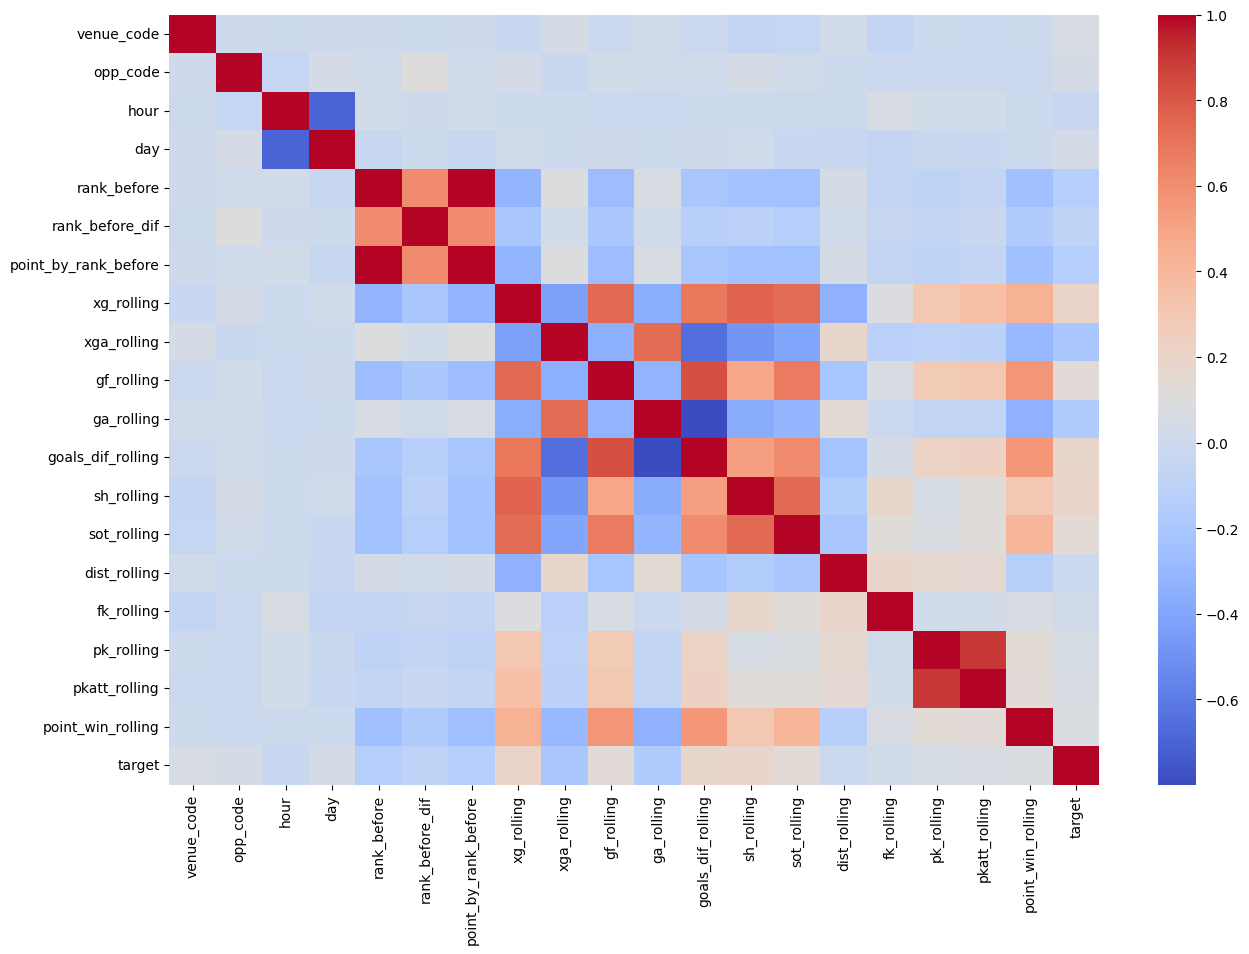

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(matches_rolling[predictors+['target']].corr(), cmap='coolwarm')
plt.show()

### Mối tương quan giữa Venue (Sân nhà - Sân khách) và Target

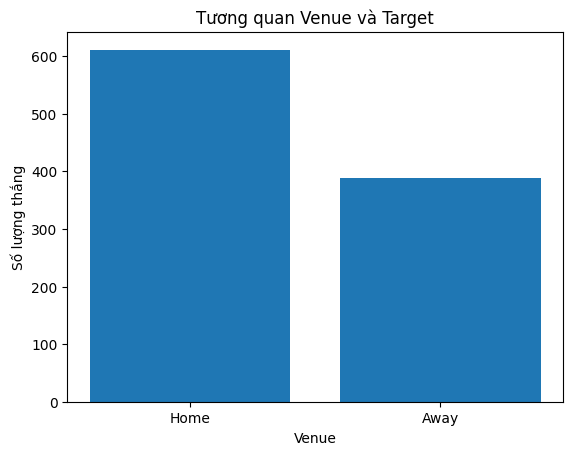

In [ ]:
# Tạo DataFrame mẫu
data = {
    'Venue': ['Home', 'Away'],
    'Target': [sum(target == 0 for target in matches['target']), sum(target == 1 for target in  matches['target'])]
}
df = pd.DataFrame(data)
plt.bar(df['Venue'], df['Target'])
plt.xlabel('Venue')
plt.ylabel('Số lượng thắng')
plt.title('Tương quan Venue và Target')
plt.show()

_Nhận xét : Sân nhà thì chiếm tỉ lệ thắng cao hơn sân khách

### Biểu đồ mật độ 2D Density plot thể hiện mối tương quan giữa xếp hạng mùa trước đội bóng và Target

C:\Users\Tienh\AppData\Local\Temp\ipykernel_18772\1286683317.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  density_plot = sns.kdeplot(data=df, x='rank_before', y='kết quả thắng thua', cmap='viridis', shade=True)


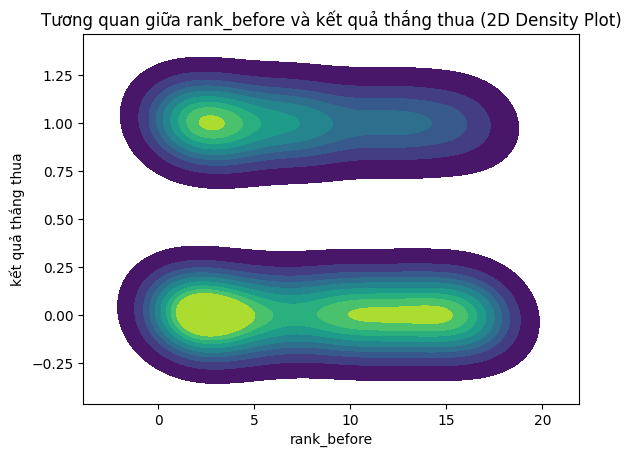

In [ ]:
import matplotlib.pyplot as plt
# Dữ liệu rank_before và mật độ thắng thua
rank_before = matches['rank_before']
win_loss_density = matches['target']
import seaborn as sns
# Tạo DataFrame từ dữ liệu
data = {'rank_before': rank_before, 'kết quả thắng thua': win_loss_density}
df = pd.DataFrame(data)
# Vẽ biểu đồ 2D Density plot
density_plot = sns.kdeplot(data=df, x='rank_before', y='kết quả thắng thua', cmap='viridis', shade=True)
plt.title('Tương quan giữa rank_before và kết quả thắng thua (2D Density Plot)')
plt.show()

Nhận xét :  
* Từ biểu đồ ta nhận thấy Mật độ tập trung dữ liệu khi rank của mùa trước Thấp (tương ứng với rank có giá trị 10 trở lên) thì sẽ đạt kết quả Target 0(Thua hoặc hòa)
* Ngược lại khi rank cao (1-5) thì dữ liệu tập trung ở target 1(thắng) và vẫn có một vài dữ liệu rank cao nhưng vẫn đạt kết quả target 0(Thua hoặc hòa)

### Biểu đồ tương quan giữa point_by_rank_before và target

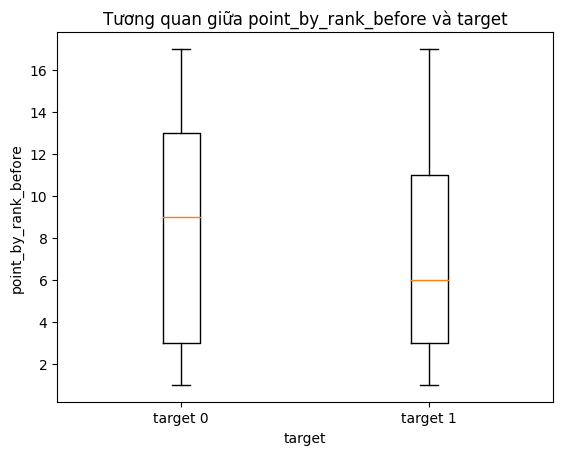

In [ ]:
import matplotlib.pyplot as plt
# Dữ liệu point_by_rank_before và target
point_by_rank_before = matches['point_by_rank_before']
win_loss_results = matches['target']
# Tạo DataFrame từ dữ liệu
data = {'point_by_rank_before': point_by_rank_before, 'target': win_loss_results}
df = pd.DataFrame(data)
# Vẽ biểu đồ Boxplot
plt.boxplot([df[df['target'] == 0]['point_by_rank_before'], df[df['target'] == 1]['point_by_rank_before']],
            labels=['target 0', 'target 1'])
plt.xlabel('target')
plt.ylabel('point_by_rank_before')
plt.title('Tương quan giữa point_by_rank_before và target')
plt.show()

Nhận xét: ta thấy điểm của mùa trước càng cao thì sẽ có kết quả thắng càng cao và ngược lại

## Lựa chọn đặc trưng và các siêu tham số với mô hình

In [ ]:
def select_best_featurest(X, y, model,k):
    model.fit(X, y)
    feature_importance = model.feature_importances_
    feature_importance = list(zip(X.columns, feature_importance))
    feature_importance = sorted(feature_importance, key=lambda x : x[1], reverse=True)
    feature_importance = feature_importance[:k]
    return feature_importance

In [ ]:
def analyze(model, X_train, y_train, X_test, y_test):    
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    preds = model.predict(X_test)
    combined = pd.DataFrame(dict(actual=y_test, predicted=preds), index=X_test.index)
    combined = combined.merge(matches_rolling[["date","season","round", "comp", "team", "opponent",'venue', "result"]], left_index=True, right_index=True)
    return combined

In [ ]:
def make_train_test(data,feature_pred): 
    train = data[(data["date"] <= '2022-02-01')]
    test = data[data["date"] > '2022-02-01']
    # Tách features và target
    X_train = train[feature_pred]
    y_train = train['target']
    X_test = test[feature_pred]
    y_test = test['target']
    return X_train,y_train,X_test,y_test

In [ ]:
def found_sample_weith(y_train):
    class_counts = y_train.value_counts()
    minority_class = class_counts.idxmin()
    majority_class = class_counts.idxmax()
    count_minority = class_counts[minority_class]
    count_majority = class_counts[majority_class]
    weight_majority = count_minority / count_majority - 0.05
    # weight_majority xấp xỉ 0,6 với size 10000 và 1000
    minority_class = 1
    sample_weights = np.where(y_train == minority_class, minority_class, weight_majority)  
    return sample_weights

In [ ]:
def select_predictions_gb(X_train,y_train,X_test,y_test):
    number_feature = list(range(len(predictors), 13, -1))
    my_list = []
    for i in number_feature:
        features = select_best_featurest(X_train,y_train,GradientBoostingClassifier(),i)
        best_features = []
        for feature, _ in features:
            best_features.append(feature)

        X_train = X_train[best_features]
        X_test = X_test[best_features]

        model = GradientBoostingClassifier(random_state = 5)
        params = {
            'learning_rate': [0.01, 0.05, 0.1],
            'min_samples_leaf': [2, 3, 5],   
            'min_samples_split' : [10, 12, 13],
            'max_depth': [2,3]
        }
        model_cv = GridSearchCV(model, params, cv = 5, n_jobs = -1, verbose = False)
        
        # Xử lý mất cân bằng dữ liệu
        sample_weights = found_sample_weith(y_train)
      
        model_cv.fit(X_train,y_train,sample_weight = sample_weights)
        model = model_cv.best_estimator_

        preds = model.predict(X_test)
        accurancy = precision_score(y_test,preds)  
        
        auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        my_list.append([auc_test, accurancy, model, best_features, i])
    return my_list


def select_predictions_rd(X_train,y_train,X_test,y_test):
    number_feature = list(range(len(predictors), 13, -1))
    my_list = []
    for i in number_feature:
        features = select_best_featurest(X_train,y_train,RandomForestClassifier(),i)
        best_features = []
        for feature, _ in features:
            best_features.append(feature)

        X_train = X_train[best_features]
        X_test = X_test[best_features]

        model = RandomForestClassifier(random_state = 5)
        params = {
                'max_depth':[2,3,5],
                'min_samples_split': [5, 10, 15 ],
                'min_samples_leaf': [2, 5, 15],
                'n_estimators' : [100,150]
                }
        model_cv = GridSearchCV(model, params, cv = 5, n_jobs = -1, verbose = False)
        
        # Xử lý mất cân bằng dữ liệu
        # Tính toán sample_weights dựa trên chênh lệch giữa hai lớp
        sample_weights = found_sample_weith(y_train)
      
        model_cv.fit(X_train,y_train,sample_weight = sample_weights)
        model = model_cv.best_estimator_

        preds = model.predict(X_test)
        accurancy = precision_score(y_test,preds)  
        
        auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        my_list.append([auc_test, accurancy, model, best_features, i])
    return my_list

In [ ]:
matches_rolling.head(10)

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,gf_rolling,ga_rolling,goals_dif_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling,point_win_rolling
0,2021-04-03,20:00,Premier League,Matchweek 30,7,Home,L,0,3,Liverpool,...,2.000000,1.666667,0.333333,14.333333,3.333333,18.733333,0.000000,0.333333,0.333333,0.666667
1,2021-04-11,19:00,Premier League,Matchweek 31,8,Away,W,3,0,Sheffield Utd,...,1.666667,2.333333,-0.666667,10.333333,3.333333,19.866667,0.000000,0.333333,0.333333,1.000000
2,2021-04-18,13:30,Premier League,Matchweek 32,8,Home,D,1,1,Fulham,...,2.000000,2.000000,0.000000,11.000000,4.333333,18.466667,0.333333,0.000000,0.000000,1.000000
3,2021-04-23,20:00,Premier League,Matchweek 33,6,Home,L,0,1,Everton,...,1.333333,1.333333,0.000000,11.666667,4.000000,17.733333,0.666667,0.000000,0.000000,1.000000
4,2021-05-02,14:00,Premier League,Matchweek 34,8,Away,W,2,0,Newcastle Utd,...,1.333333,0.666667,0.666667,15.333333,4.333333,17.533333,0.666667,0.000000,0.000000,1.000000
5,2021-05-09,19:00,Premier League,Matchweek 35,8,Home,W,3,1,West Brom,...,1.000000,0.666667,0.333333,17.000000,4.000000,17.100000,0.666667,0.000000,0.000000,1.000000
6,2021-05-12,20:15,Premier League,Matchweek 36,4,Away,W,1,0,Chelsea,...,1.666667,0.666667,1.000000,16.000000,4.666667,18.333333,0.666667,0.000000,0.000000,1.666667
7,2021-05-19,19:00,Premier League,Matchweek 37,4,Away,W,3,1,Crystal Palace,...,2.000000,0.333333,1.666667,13.000000,4.333333,19.133333,0.666667,0.000000,0.000000,2.000000
8,2021-05-23,16:00,Premier League,Matchweek 38,8,Home,W,2,0,Brighton,...,2.333333,0.666667,1.666667,8.666667,4.000000,18.200000,0.333333,0.000000,0.000000,2.000000
9,2021-08-13,20:00,Premier League,Matchweek 1,6,Away,L,0,2,Brentford,...,2.000000,0.333333,1.666667,9.000000,3.333333,18.566667,0.333333,0.000000,0.000000,2.000000


In [ ]:
X_train,y_train,X_test,y_test = make_train_test(matches_rolling,predictors)

In [ ]:
y_train.value_counts()

target
0    368
1    231
Name: count, dtype: int64

In [ ]:
y_test.value_counts()

target
0    197
1    135
Name: count, dtype: int64

### GradientBoostingClassifier

In [ ]:
my_list = select_predictions_gb(X_train, y_train, X_test, y_test)
display(pd.DataFrame(my_list, columns=["AUC Score Test","Accuracy Score" ,"Model", "Features","NumFe"]))

,AUC Score Test,Accuracy Score,Model,Features,NumFe
0,0.626998,0.527397,([DecisionTreeRegressor(criterion='friedman_ms...,"[dist_rolling, xg_rolling, opp_code, xga_rolli...",19
1,0.633653,0.521127,([DecisionTreeRegressor(criterion='friedman_ms...,"[dist_rolling, xg_rolling, opp_code, xga_rolli...",18
2,0.663659,0.547445,([DecisionTreeRegressor(criterion='friedman_ms...,"[dist_rolling, xg_rolling, opp_code, xga_rolli...",17
3,0.649521,0.528455,([DecisionTreeRegressor(criterion='friedman_ms...,"[dist_rolling, xg_rolling, opp_code, sh_rollin...",16
4,0.650085,0.568182,([DecisionTreeRegressor(criterion='friedman_ms...,"[dist_rolling, xg_rolling, opp_code, sh_rollin...",15
5,0.659410,0.552239,([DecisionTreeRegressor(criterion='friedman_ms...,"[dist_rolling, opp_code, xg_rolling, xga_rolli...",14


In [ ]:
# Xem các siêu tham số cho model
list_ = []
for _,_,i,_,_ in my_list:
        print(i)

GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=2,
                           min_samples_split=12, random_state=5)
GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=2,
                           min_samples_split=12, random_state=5)
GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=3,
                           min_samples_split=10, random_state=5)
GradientBoostingClassifier(min_samples_leaf=5, min_samples_split=10,
                           random_state=5)
GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=3,
                           min_samples_split=13, random_state=5)
GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=3,
                           min_samples_split=10, random_state=5)


In [ ]:
# Xem số lượng lựa chọn các thuộc tính
list_ = []
for _,_,_,i,_ in my_list:
    print(i)
    for j in i:
        list_.append(j)
collections.Counter(list_)

['dist_rolling', 'xg_rolling', 'opp_code', 'xga_rolling', 'sh_rolling', 'rank_before_dif', 'sot_rolling', 'goals_dif_rolling', 'gf_rolling', 'fk_rolling', 'rank_before', 'point_by_rank_before', 'hour', 'venue_code', 'day', 'point_win_rolling', 'ga_rolling', 'pk_rolling', 'pkatt_rolling']
['dist_rolling', 'xg_rolling', 'opp_code', 'xga_rolling', 'sh_rolling', 'rank_before_dif', 'sot_rolling', 'goals_dif_rolling', 'gf_rolling', 'fk_rolling', 'rank_before', 'point_by_rank_before', 'hour', 'venue_code', 'day', 'point_win_rolling', 'ga_rolling', 'pk_rolling']
['dist_rolling', 'xg_rolling', 'opp_code', 'xga_rolling', 'sh_rolling', 'rank_before_dif', 'sot_rolling', 'goals_dif_rolling', 'gf_rolling', 'point_by_rank_before', 'fk_rolling', 'rank_before', 'hour', 'venue_code', 'day', 'point_win_rolling', 'ga_rolling']
['dist_rolling', 'xg_rolling', 'opp_code', 'sh_rolling', 'rank_before_dif', 'xga_rolling', 'sot_rolling', 'goals_dif_rolling', 'rank_before', 'point_by_rank_before', 'gf_rolling', '

Counter({'dist_rolling': 6,
         'xg_rolling': 6,
         'opp_code': 6,
         'xga_rolling': 6,
         'sh_rolling': 6,
         'rank_before_dif': 6,
         'sot_rolling': 6,
         'goals_dif_rolling': 6,
         'gf_rolling': 6,
         'fk_rolling': 6,
         'rank_before': 6,
         'point_by_rank_before': 6,
         'hour': 6,
         'day': 6,
         'venue_code': 5,
         'ga_rolling': 4,
         'point_win_rolling': 3,
         'pk_rolling': 2,
         'pkatt_rolling': 1})

In [ ]:
best_features = ['dist_rolling', 'xg_rolling', 'opp_code', 'xga_rolling', 'sh_rolling', 'rank_before_dif', 'sot_rolling', 'goals_dif_rolling', 'gf_rolling', 'point_by_rank_before', 'fk_rolling', 'hour', 'rank_before', 'venue_code', 'day', 'point_win_rolling', 'ga_rolling']

In [ ]:
best_model = GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=3,
                           min_samples_split=15, random_state=5, max_depth=2)
X_train, y_train, X_test, y_test = make_train_test(matches_rolling, best_features)
sample_weights = found_sample_weith(y_train)
best_model.fit(X_train, y_train, sample_weight = sample_weights)

GradientBoostingClassifier(learning_rate=0.05, max_depth=2, min_samples_leaf=3,
                           min_samples_split=15, random_state=5)

### Đánh giá : GradientBoostingClassifier

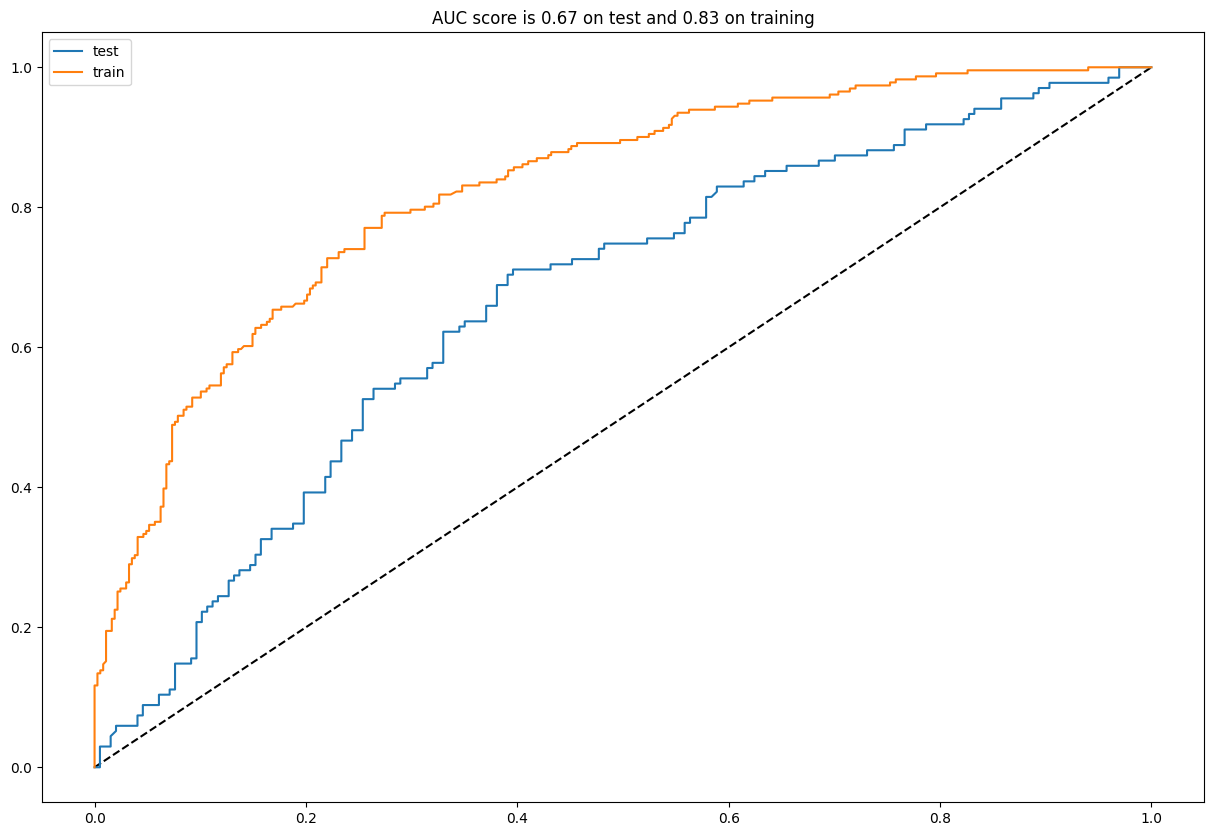

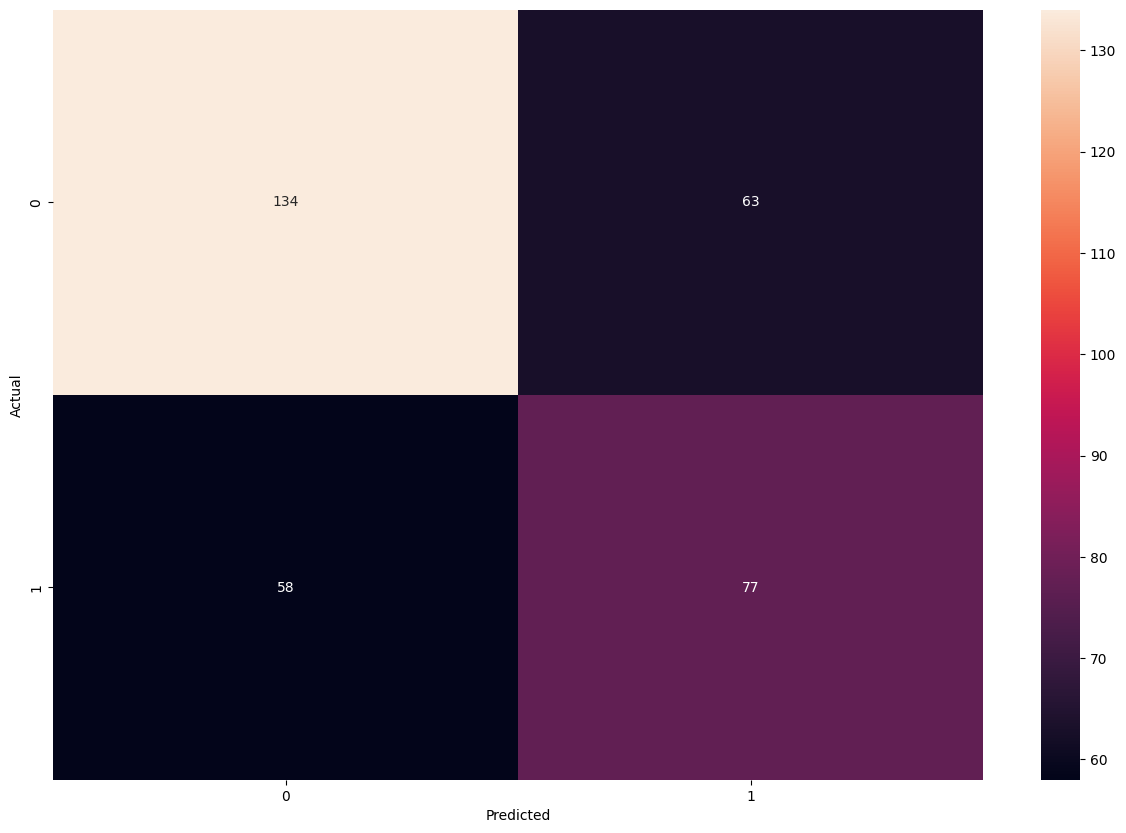

In [ ]:
predicted_match = analyze(best_model, X_train[best_features], y_train, X_test[best_features], y_test)

In [ ]:
predicted_match.sort_values(["date"], ascending = True).head(20)

,actual,predicted,date,season,round,comp,team,opponent,venue,result
811,0,0,2022-02-05,2021,Matchweek 17,Premier League,Watford,Burnley,Away,D
204,0,0,2022-02-05,2021,Matchweek 17,Premier League,Burnley,Watford,Home,D
593,0,0,2022-02-08,2021,Matchweek 24,Premier League,Manchester Utd,Burnley,Away,D
639,1,0,2022-02-08,2021,Matchweek 24,Premier League,Newcastle Utd,Everton,Home,W
348,0,0,2022-02-08,2021,Matchweek 24,Premier League,Everton,Newcastle Utd,Away,L
870,1,1,2022-02-08,2021,Matchweek 24,Premier League,West Ham,Watford,Home,W
812,0,1,2022-02-08,2021,Matchweek 24,Premier League,Watford,West Ham,Away,L
205,0,0,2022-02-08,2021,Matchweek 24,Premier League,Burnley,Manchester Utd,Home,D
547,1,1,2022-02-09,2021,Matchweek 24,Premier League,Manchester City,Brentford,Home,W
730,1,0,2022-02-09,2021,Matchweek 24,Premier League,Southampton,Tottenham,Away,W


In [ ]:
merged = predicted_match.merge(predicted_match, left_on=["date", "team"], right_on=["date", "opponent"])
merged.head(30)

,actual_x,predicted_x,date,season_x,round_x,comp_x,team_x,opponent_x,venue_x,result_x,actual_y,predicted_y,season_y,round_y,comp_y,team_y,opponent_y,venue_y,result_y
0,1,1,2022-02-10,2021,Matchweek 24,Premier League,Arsenal,Wolves,Away,W,0,1,2021,Matchweek 24,Premier League,Wolves,Arsenal,Home,L
1,1,1,2022-02-19,2021,Matchweek 26,Premier League,Arsenal,Brentford,Home,W,0,0,2021,Matchweek 26,Premier League,Brentford,Arsenal,Away,L
2,1,1,2022-02-24,2021,Matchweek 20,Premier League,Arsenal,Wolves,Home,W,0,0,2021,Matchweek 20,Premier League,Wolves,Arsenal,Away,L
3,1,1,2022-03-06,2021,Matchweek 28,Premier League,Arsenal,Watford,Away,W,0,1,2021,Matchweek 28,Premier League,Watford,Arsenal,Home,L
4,1,1,2022-03-13,2021,Matchweek 29,Premier League,Arsenal,Leicester City,Home,W,0,1,2021,Matchweek 29,Premier League,Leicester City,Arsenal,Away,L
5,0,1,2022-03-16,2021,Matchweek 27,Premier League,Arsenal,Liverpool,Home,L,1,0,2021,Matchweek 27,Premier League,Liverpool,Arsenal,Away,W
6,1,1,2022-03-19,2021,Matchweek 30,Premier League,Arsenal,Aston Villa,Away,W,0,0,2021,Matchweek 30,Premier League,Aston Villa,Arsenal,Home,L
7,0,1,2022-04-04,2021,Matchweek 31,Premier League,Arsenal,Crystal Palace,Away,L,1,0,2021,Matchweek 31,Premier League,Crystal Palace,Arsenal,Home,W
8,0,1,2022-04-09,2021,Matchweek 32,Premier League,Arsenal,Brighton,Home,L,1,0,2021,Matchweek 32,Premier League,Brighton,Arsenal,Away,W
9,0,1,2022-04-16,2021,Matchweek 33,Premier League,Arsenal,Southampton,Away,L,1,0,2021,Matchweek 33,Premier League,Southampton,Arsenal,Home,W


In [ ]:
merged[merged['team_x'] == 'Arsenal']

,actual_x,predicted_x,date,season_x,round_x,comp_x,team_x,opponent_x,venue_x,result_x,actual_y,predicted_y,season_y,round_y,comp_y,team_y,opponent_y,venue_y,result_y
0,1,1,2022-02-10,2021,Matchweek 24,Premier League,Arsenal,Wolves,Away,W,0,1,2021,Matchweek 24,Premier League,Wolves,Arsenal,Home,L
1,1,1,2022-02-19,2021,Matchweek 26,Premier League,Arsenal,Brentford,Home,W,0,0,2021,Matchweek 26,Premier League,Brentford,Arsenal,Away,L
2,1,1,2022-02-24,2021,Matchweek 20,Premier League,Arsenal,Wolves,Home,W,0,0,2021,Matchweek 20,Premier League,Wolves,Arsenal,Away,L
3,1,1,2022-03-06,2021,Matchweek 28,Premier League,Arsenal,Watford,Away,W,0,1,2021,Matchweek 28,Premier League,Watford,Arsenal,Home,L
4,1,1,2022-03-13,2021,Matchweek 29,Premier League,Arsenal,Leicester City,Home,W,0,1,2021,Matchweek 29,Premier League,Leicester City,Arsenal,Away,L
5,0,1,2022-03-16,2021,Matchweek 27,Premier League,Arsenal,Liverpool,Home,L,1,0,2021,Matchweek 27,Premier League,Liverpool,Arsenal,Away,W
6,1,1,2022-03-19,2021,Matchweek 30,Premier League,Arsenal,Aston Villa,Away,W,0,0,2021,Matchweek 30,Premier League,Aston Villa,Arsenal,Home,L
7,0,1,2022-04-04,2021,Matchweek 31,Premier League,Arsenal,Crystal Palace,Away,L,1,0,2021,Matchweek 31,Premier League,Crystal Palace,Arsenal,Home,W
8,0,1,2022-04-09,2021,Matchweek 32,Premier League,Arsenal,Brighton,Home,L,1,0,2021,Matchweek 32,Premier League,Brighton,Arsenal,Away,W
9,0,1,2022-04-16,2021,Matchweek 33,Premier League,Arsenal,Southampton,Away,L,1,0,2021,Matchweek 33,Premier League,Southampton,Arsenal,Home,W


In [ ]:
merged[merged['team_x'] == 'Manchester Utd'].head(20)

,actual_x,predicted_x,date,season_x,round_x,comp_x,team_x,opponent_x,venue_x,result_x,actual_y,predicted_y,season_y,round_y,comp_y,team_y,opponent_y,venue_y,result_y
199,0,0,2022-02-08,2021,Matchweek 24,Premier League,Manchester Utd,Burnley,Away,D,0,0,2021,Matchweek 24,Premier League,Burnley,Manchester Utd,Home,D
200,0,1,2022-02-12,2021,Matchweek 25,Premier League,Manchester Utd,Southampton,Home,D,0,0,2021,Matchweek 25,Premier League,Southampton,Manchester Utd,Away,D
201,1,1,2022-02-15,2021,Matchweek 18,Premier League,Manchester Utd,Brighton,Home,W,0,0,2021,Matchweek 18,Premier League,Brighton,Manchester Utd,Away,L
202,1,1,2022-02-20,2021,Matchweek 26,Premier League,Manchester Utd,Leeds United,Away,W,0,0,2021,Matchweek 26,Premier League,Leeds United,Manchester Utd,Home,L
203,0,1,2022-02-26,2021,Matchweek 27,Premier League,Manchester Utd,Watford,Home,D,0,0,2021,Matchweek 27,Premier League,Watford,Manchester Utd,Away,D
204,0,1,2022-03-06,2021,Matchweek 28,Premier League,Manchester Utd,Manchester City,Away,L,1,1,2021,Matchweek 28,Premier League,Manchester City,Manchester Utd,Home,W
205,1,1,2022-03-12,2021,Matchweek 29,Premier League,Manchester Utd,Tottenham,Home,W,0,0,2021,Matchweek 29,Premier League,Tottenham,Manchester Utd,Away,L
206,0,0,2022-04-02,2021,Matchweek 31,Premier League,Manchester Utd,Leicester City,Home,D,0,0,2021,Matchweek 31,Premier League,Leicester City,Manchester Utd,Away,D
207,0,0,2022-04-09,2021,Matchweek 32,Premier League,Manchester Utd,Everton,Away,L,1,0,2021,Matchweek 32,Premier League,Everton,Manchester Utd,Home,W
208,1,1,2022-04-16,2021,Matchweek 33,Premier League,Manchester Utd,Norwich City,Home,W,0,0,2021,Matchweek 33,Premier League,Norwich City,Manchester Utd,Away,L


In [ ]:
count = merged[(merged["predicted_x"] == 1) & (merged["predicted_y"] == 0)]["actual_x"].value_counts()

In [ ]:
count = np.array(count)
print(f"1 : {count[0]}")
print(f"0 : {count[1]}")
print((count[0]/(count[0]+count[1]))*100)

1 : 59
0 : 35
62.76595744680851


In [ ]:
count = merged[(merged["predicted_x"] == 0) & (merged["predicted_y"] == 1)]["actual_x"].value_counts()

In [ ]:
count = np.array(count)
print(f"0 : {count[1]}")
print(f"1 : {count[0]}")
print((count[0]/(count[0]+count[1]))*100)

0 : 21
1 : 73
77.6595744680851


### RandomForestClassifier

In [ ]:
X_train,y_train,X_test,y_test = make_train_test(matches_rolling,predictors)

In [ ]:
my_list = select_predictions_rd(X_train, y_train, X_test, y_test)
display(pd.DataFrame(my_list, columns=["AUC Score Test","Accuracy Score" ,"Model", "Features","NumFe"]))

,AUC Score Test,Accuracy Score,Model,Features,NumFe
0,0.641549,0.568182,"(DecisionTreeClassifier(max_depth=3, max_featu...","[dist_rolling, xg_rolling, xga_rolling, sh_rol...",19
1,0.662794,0.568807,"(DecisionTreeClassifier(max_depth=5, max_featu...","[dist_rolling, xg_rolling, sh_rolling, xga_rol...",18
2,0.656665,0.596330,"(DecisionTreeClassifier(max_depth=5, max_featu...","[dist_rolling, xg_rolling, sh_rolling, rank_be...",17
3,0.647077,0.538462,"(DecisionTreeClassifier(max_depth=5, max_featu...","[dist_rolling, xg_rolling, sh_rolling, xga_rol...",16
4,0.661327,0.576271,"(DecisionTreeClassifier(max_depth=5, max_featu...","[dist_rolling, xg_rolling, sh_rolling, xga_rol...",15
5,0.649069,0.583333,"(DecisionTreeClassifier(max_depth=3, max_featu...","[dist_rolling, xg_rolling, xga_rolling, sh_rol...",14


In [ ]:
# Xem các siêu tham số cho model
list_ = []
for _,_,i,_,_ in my_list:
    print(i)

RandomForestClassifier(max_depth=3, min_samples_leaf=15, min_samples_split=5,
                       random_state=5)
RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                       random_state=5)
RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=15,
                       random_state=5)
RandomForestClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=5,
                       random_state=5)
RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=150, random_state=5)
RandomForestClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=15,
                       n_estimators=150, random_state=5)


In [ ]:
# Xem số lượng lựa chọn các thuộc tính
list_ = []
for _,_,_,i,_ in my_list:
    print(i)
    for j in i:
        list_.append(j)
collections.Counter(list_)

['dist_rolling', 'xg_rolling', 'xga_rolling', 'sh_rolling', 'opp_code', 'rank_before_dif', 'sot_rolling', 'point_by_rank_before', 'goals_dif_rolling', 'rank_before', 'gf_rolling', 'hour', 'ga_rolling', 'point_win_rolling', 'fk_rolling', 'day', 'pk_rolling', 'venue_code', 'pkatt_rolling']
['dist_rolling', 'xg_rolling', 'sh_rolling', 'xga_rolling', 'rank_before_dif', 'opp_code', 'sot_rolling', 'goals_dif_rolling', 'point_by_rank_before', 'rank_before', 'ga_rolling', 'gf_rolling', 'hour', 'fk_rolling', 'point_win_rolling', 'day', 'venue_code', 'pkatt_rolling']
['dist_rolling', 'xg_rolling', 'sh_rolling', 'rank_before_dif', 'xga_rolling', 'opp_code', 'sot_rolling', 'goals_dif_rolling', 'rank_before', 'point_by_rank_before', 'gf_rolling', 'hour', 'ga_rolling', 'fk_rolling', 'point_win_rolling', 'day', 'pkatt_rolling']
['dist_rolling', 'xg_rolling', 'sh_rolling', 'xga_rolling', 'rank_before_dif', 'opp_code', 'sot_rolling', 'point_by_rank_before', 'rank_before', 'goals_dif_rolling', 'ga_rolli

Counter({'dist_rolling': 6,
         'xg_rolling': 6,
         'xga_rolling': 6,
         'sh_rolling': 6,
         'opp_code': 6,
         'rank_before_dif': 6,
         'sot_rolling': 6,
         'point_by_rank_before': 6,
         'goals_dif_rolling': 6,
         'rank_before': 6,
         'gf_rolling': 6,
         'hour': 6,
         'ga_rolling': 6,
         'point_win_rolling': 6,
         'fk_rolling': 5,
         'day': 4,
         'pkatt_rolling': 3,
         'venue_code': 2,
         'pk_rolling': 1})

In [ ]:
best_features = [
    'dist_rolling', 'xg_rolling', 'sh_rolling', 'rank_before_dif', 'xga_rolling', 'opp_code', 'sot_rolling', 'goals_dif_rolling', 'rank_before', 'point_by_rank_before', 'gf_rolling', 'hour', 'ga_rolling', 'fk_rolling', 'point_win_rolling', 'day', 'pkatt_rolling']


In [ ]:
X_train, y_train, X_test, y_test = make_train_test(matches_rolling, best_features)

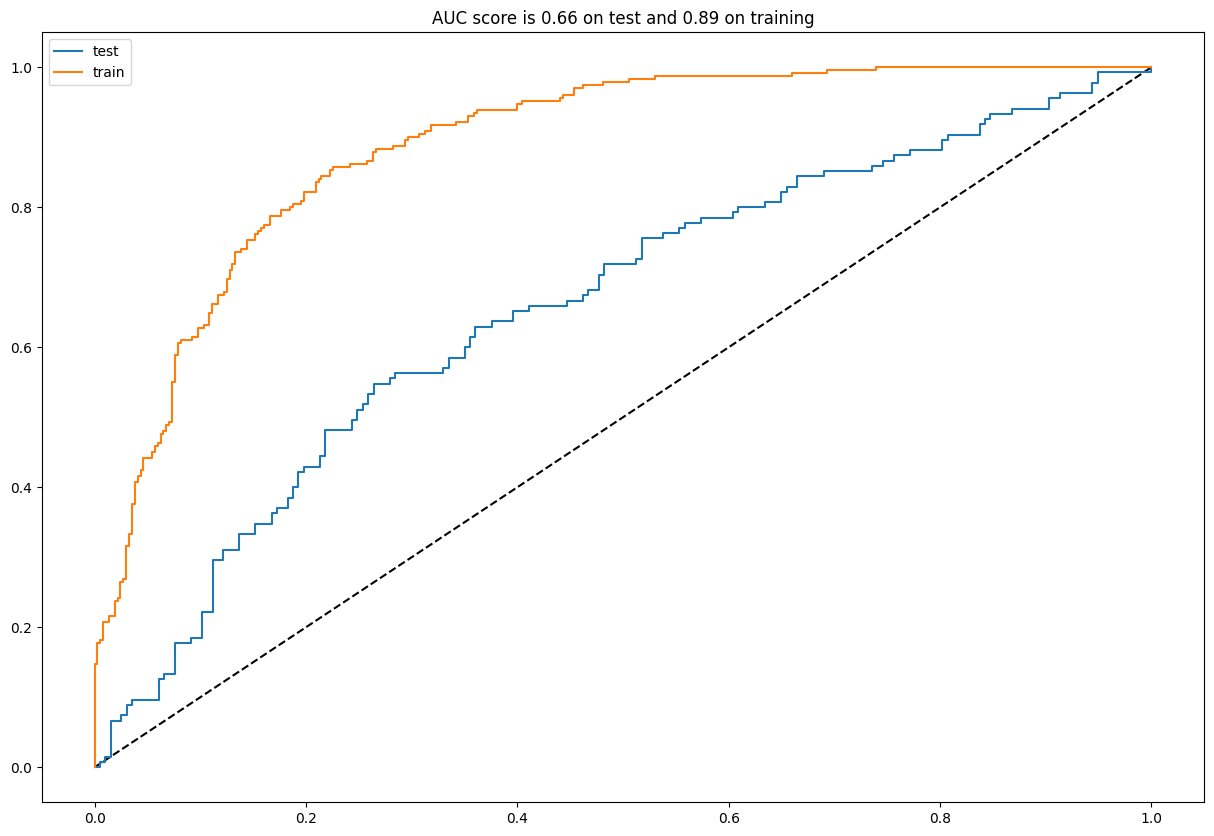

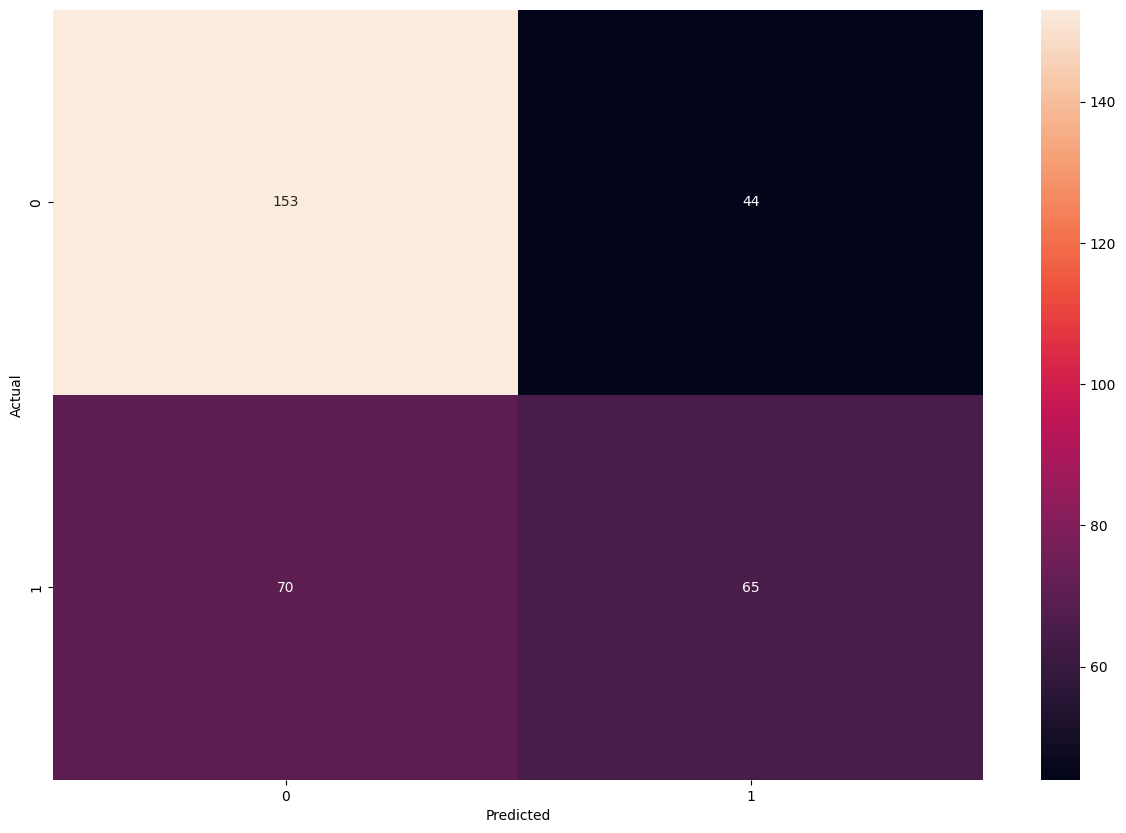

In [ ]:
best_model = RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=15,
                       random_state=5)
sample_weights = found_sample_weith(y_train)
best_model.fit(X_train, y_train, sample_weight = sample_weights)
predicted_match = analyze(best_model, X_train[best_features], y_train, X_test[best_features], y_test)

### Đánh giá : RandomForestClassifier

In [ ]:
predicted_match.sort_values(["date"], ascending = True).head(20)
merged = predicted_match.merge(predicted_match, left_on=["date", "team"], right_on=["date", "opponent"])
merged.head(30)

,actual_x,predicted_x,date,season_x,round_x,comp_x,team_x,opponent_x,venue_x,result_x,actual_y,predicted_y,season_y,round_y,comp_y,team_y,opponent_y,venue_y,result_y
0,1,1,2022-02-10,2021,Matchweek 24,Premier League,Arsenal,Wolves,Away,W,0,0,2021,Matchweek 24,Premier League,Wolves,Arsenal,Home,L
1,1,1,2022-02-19,2021,Matchweek 26,Premier League,Arsenal,Brentford,Home,W,0,0,2021,Matchweek 26,Premier League,Brentford,Arsenal,Away,L
2,1,1,2022-02-24,2021,Matchweek 20,Premier League,Arsenal,Wolves,Home,W,0,0,2021,Matchweek 20,Premier League,Wolves,Arsenal,Away,L
3,1,1,2022-03-06,2021,Matchweek 28,Premier League,Arsenal,Watford,Away,W,0,0,2021,Matchweek 28,Premier League,Watford,Arsenal,Home,L
4,1,1,2022-03-13,2021,Matchweek 29,Premier League,Arsenal,Leicester City,Home,W,0,1,2021,Matchweek 29,Premier League,Leicester City,Arsenal,Away,L
5,0,1,2022-03-16,2021,Matchweek 27,Premier League,Arsenal,Liverpool,Home,L,1,1,2021,Matchweek 27,Premier League,Liverpool,Arsenal,Away,W
6,1,1,2022-03-19,2021,Matchweek 30,Premier League,Arsenal,Aston Villa,Away,W,0,0,2021,Matchweek 30,Premier League,Aston Villa,Arsenal,Home,L
7,0,1,2022-04-04,2021,Matchweek 31,Premier League,Arsenal,Crystal Palace,Away,L,1,0,2021,Matchweek 31,Premier League,Crystal Palace,Arsenal,Home,W
8,0,1,2022-04-09,2021,Matchweek 32,Premier League,Arsenal,Brighton,Home,L,1,0,2021,Matchweek 32,Premier League,Brighton,Arsenal,Away,W
9,0,1,2022-04-16,2021,Matchweek 33,Premier League,Arsenal,Southampton,Away,L,1,0,2021,Matchweek 33,Premier League,Southampton,Arsenal,Home,W


In [ ]:
merged[merged['team_x'] == 'Everton']

,actual_x,predicted_x,date,season_x,round_x,comp_x,team_x,opponent_x,venue_x,result_x,actual_y,predicted_y,season_y,round_y,comp_y,team_y,opponent_y,venue_y,result_y
115,0,0,2022-02-08,2021,Matchweek 24,Premier League,Everton,Newcastle Utd,Away,L,1,0,2021,Matchweek 24,Premier League,Newcastle Utd,Everton,Home,W
116,1,0,2022-02-12,2021,Matchweek 25,Premier League,Everton,Leeds United,Home,W,0,1,2021,Matchweek 25,Premier League,Leeds United,Everton,Away,L
117,0,1,2022-02-19,2021,Matchweek 26,Premier League,Everton,Southampton,Away,L,1,0,2021,Matchweek 26,Premier League,Southampton,Everton,Home,W
118,0,0,2022-02-26,2021,Matchweek 27,Premier League,Everton,Manchester City,Home,L,1,1,2021,Matchweek 27,Premier League,Manchester City,Everton,Away,W
119,0,0,2022-03-07,2021,Matchweek 28,Premier League,Everton,Tottenham,Away,L,1,0,2021,Matchweek 28,Premier League,Tottenham,Everton,Home,W
120,0,0,2022-03-13,2021,Matchweek 29,Premier League,Everton,Wolves,Home,L,1,0,2021,Matchweek 29,Premier League,Wolves,Everton,Away,W
121,1,0,2022-03-17,2021,Matchweek 20,Premier League,Everton,Newcastle Utd,Home,W,0,0,2021,Matchweek 20,Premier League,Newcastle Utd,Everton,Away,L
122,0,0,2022-04-03,2021,Matchweek 31,Premier League,Everton,West Ham,Away,L,1,0,2021,Matchweek 31,Premier League,West Ham,Everton,Home,W
123,0,1,2022-04-06,2021,Matchweek 19,Premier League,Everton,Burnley,Away,L,1,0,2021,Matchweek 19,Premier League,Burnley,Everton,Home,W
124,1,0,2022-04-09,2021,Matchweek 32,Premier League,Everton,Manchester Utd,Home,W,0,0,2021,Matchweek 32,Premier League,Manchester Utd,Everton,Away,L


In [ ]:
merged[merged['team_x'] == 'Manchester Utd'].head(20)

,actual_x,predicted_x,date,season_x,round_x,comp_x,team_x,opponent_x,venue_x,result_x,actual_y,predicted_y,season_y,round_y,comp_y,team_y,opponent_y,venue_y,result_y
199,0,1,2022-02-08,2021,Matchweek 24,Premier League,Manchester Utd,Burnley,Away,D,0,0,2021,Matchweek 24,Premier League,Burnley,Manchester Utd,Home,D
200,0,1,2022-02-12,2021,Matchweek 25,Premier League,Manchester Utd,Southampton,Home,D,0,0,2021,Matchweek 25,Premier League,Southampton,Manchester Utd,Away,D
201,1,1,2022-02-15,2021,Matchweek 18,Premier League,Manchester Utd,Brighton,Home,W,0,0,2021,Matchweek 18,Premier League,Brighton,Manchester Utd,Away,L
202,1,1,2022-02-20,2021,Matchweek 26,Premier League,Manchester Utd,Leeds United,Away,W,0,0,2021,Matchweek 26,Premier League,Leeds United,Manchester Utd,Home,L
203,0,1,2022-02-26,2021,Matchweek 27,Premier League,Manchester Utd,Watford,Home,D,0,0,2021,Matchweek 27,Premier League,Watford,Manchester Utd,Away,D
204,0,1,2022-03-06,2021,Matchweek 28,Premier League,Manchester Utd,Manchester City,Away,L,1,1,2021,Matchweek 28,Premier League,Manchester City,Manchester Utd,Home,W
205,1,1,2022-03-12,2021,Matchweek 29,Premier League,Manchester Utd,Tottenham,Home,W,0,0,2021,Matchweek 29,Premier League,Tottenham,Manchester Utd,Away,L
206,0,0,2022-04-02,2021,Matchweek 31,Premier League,Manchester Utd,Leicester City,Home,D,0,0,2021,Matchweek 31,Premier League,Leicester City,Manchester Utd,Away,D
207,0,0,2022-04-09,2021,Matchweek 32,Premier League,Manchester Utd,Everton,Away,L,1,0,2021,Matchweek 32,Premier League,Everton,Manchester Utd,Home,W
208,1,0,2022-04-16,2021,Matchweek 33,Premier League,Manchester Utd,Norwich City,Home,W,0,0,2021,Matchweek 33,Premier League,Norwich City,Manchester Utd,Away,L


In [ ]:
count = merged[(merged["predicted_x"] == 1) & (merged["predicted_y"] == 0)]["actual_x"].value_counts()
count = np.array(count)
print(f"1 : {count[0]}")
print(f"0 : {count[1]}")
num1 = (count[0]/(count[0]+count[1]))*100
print(num1)

1 : 55
0 : 28
66.26506024096386


In [ ]:
count = merged[(merged["predicted_x"] == 0) & (merged["predicted_y"] == 1)]["actual_x"].value_counts()
count = np.array(count)
print(f"0 : {count[1]}")
print(f"1 : {count[0]}")
num2 = (count[0]/(count[0]+count[1]))*100
print(num2)

0 : 18
1 : 65
78.3132530120482
